# Тестовое задание на вакансию "Геоаналитик"

## Введение

**Цель:** собрать и сопоставить информацию о наличии объектов социальной
инфраструктуры в населенном пункте Яр-Сале.  

**Задачи:**
1. Используя OpenStreetMap (OSM) выгрузить данные об объектах
социальной-экономической инфраструктуры (школы, больницы,
рестораны, автозаправки и др.), расположенных на территории села
Яр-Сале (Ямало-Ненецкий автономный округ, муниципальный округ
Ямальский район, село Яр-Сале). Полный перечень объектов
необходимо определить самостоятельно.
2. Скачать слои о точках интереса и зданиях в Яр-Сале, сопоставить с
ранее собранной информацией и дополнить ее
3. Нормализовать данные и представить их в формате плоской таблицы,
включающей информацию об адресе объекта, его географических
координатах, типе объекта и источнике (ах) данных
4. Проанализировать полноту собранных данных с помощью других
открытых источников (например, Яндекс.Карты)  

**Результат выполнения задания:**
1. Задокументированный код, опубликованный в открытом репозитории
Github, с помощью которого выгружались данные
2. Файл проекта QGIS со слоями, содержащими данные о собранных
объектах
3. Нормализованная плоская таблица с информацией об объектах
4. Текст с описанием результатов анализа (предпочтительный формат: doc,
pdf, не более 5 тыс. символов).

## Загрузка библиотек

In [117]:
!pip install osmnx

In [118]:
import geopandas as gpd
import pandas as pd
import requests
import os
import osmnx as ox
import matplotlib.pyplot as plt


## Функции

In [119]:
# Функция для определения, является ли объект социальной инфраструктурой для предоставленного проекта
def is_social_infrastructure(row):
    """
    Определяет, относится ли объект к социальной инфраструктуре
    """
    # Типы объектов социальной инфраструктуры
    social_types = [
        'school', 'hospital', 'clinic', 'doctors', 'dentist', 'pharmacy',
        'kindergarten', 'library', 'community_centre', 'social_facility',
        'townhall', 'government', 'police', 'fire_station', 'post_office',
        'bank', 'marketplace', 'restaurant', 'cafe', 'fast_food', 'pub',
        'bar', 'fuel', 'place_of_worship', 'sports_centre', 'theatre',
        'cinema', 'arts_centre', 'taxi', 'bus_station'
    ]

    # Проверяю значение в колонке AMENITY
    if pd.notnull(row.get('AMENITY')) and str(row['AMENITY']).lower() in social_types:
        return True

    # Проверяю другие типы объектов
    for col in ['SHOP', 'LEISURE', 'TOURISM', 'OFFICE', 'SPORT']:
        if pd.notnull(row.get(col)):
            return True

    # Проверяю по названию на русском и английском
    social_keywords = [
        'школа', 'больница', 'поликлиника', 'врач', 'аптека', 'детский сад',
        'библиотека', 'администрация', 'полиция', 'пожарная', 'почта', 'банк',
        'рынок', 'ресторан', 'кафе', 'заправка', 'церковь', 'мечеть', 'храм',
        'спорт', 'театр', 'кино', 'такси', 'автобус', 'гостиница', 'отель',
        'school', 'hospital', 'clinic', 'pharmacy', 'kindergarten', 'library',
        'police', 'post', 'bank', 'market', 'restaurant', 'cafe', 'church',
        'sport', 'theatre', 'cinema', 'hotel'
    ]

    for name_col in ['NAME', 'NAME_RU', 'NAME_EN']:
        if pd.notnull(row.get(name_col)):
            name_lower = str(row[name_col]).lower()
            for keyword in social_keywords:
                if keyword in name_lower:
                    return True

    return False

In [120]:
# Функция удаления дубликатов по координатам
def deduplicate_by_coords(df, tolerance=0.0001):
    """
    Удаляет дубликаты по координатам с заданным допуском
    """
    # Создаю копию DataFrame
    result = df.copy()

    # Индексы для удаления
    to_drop = []

    # Для каждой строки
    for i, row_i in df.iterrows():
        # Если строка уже помечена на удаление, пропускаю
        if i in to_drop:
            continue

        # Проверяю все строки после текущей
        for j, row_j in df.iloc[i+1:].iterrows():
            # Проверяем близость координат
            if (abs(row_i['latitude'] - row_j['latitude']) < tolerance and
                abs(row_i['longitude'] - row_j['longitude']) < tolerance):
                # Помечаем на удаление
                to_drop.append(j)

    # Удаляю дубликаты
    result = result.drop(to_drop)

    print(f"Удалено {len(to_drop)} дубликатов по координатам")
    return result


In [121]:
# Функция для сопоставления объектов по координатам
def match_poi_by_coordinates(qgis_df, osm_df, threshold=0.0001):
    """Сопоставляет объекты из QGIS и OSM по близости координат"""
    # Копии DataFrame для работы
    qgis_data = qgis_df.copy()
    osm_data = osm_df.copy()

    # Для отслеживания соответствий
    matches = []
    qgis_matched_indices = set()
    osm_matched_indices = set()

    # Для каждого объекта из QGIS ищу соответствие в OSM
    for qgis_idx, qgis_row in qgis_data.iterrows():
        for osm_idx, osm_row in osm_data.iterrows():
            # Если OSM объект уже сопоставлен, пропускаем
            if osm_idx in osm_matched_indices:
                continue

            # Проверяю расстояние между точками
            if (abs(qgis_row['latitude'] - osm_row['latitude']) < threshold and
                abs(qgis_row['longitude'] - osm_row['longitude']) < threshold):

                # Нашлось соответствие
                qgis_matched_indices.add(qgis_idx)
                osm_matched_indices.add(osm_idx)

                # Добавляю в список соответствий
                matches.append({
                    'qgis_index': qgis_idx,
                    'osm_index': osm_idx,
                    'qgis_name': qgis_row['name'],
                    'osm_name': osm_row['name'],
                    'qgis_type': qgis_row['type'],
                    'osm_type': osm_row['type'],
                    'latitude': qgis_row['latitude'],
                    'longitude': qgis_row['longitude']
                })

                break  # Перехожу к следующему объекту QGIS

    # Нахожу объекты, которые есть только в QGIS
    qgis_only = qgis_data[~qgis_data.index.isin(qgis_matched_indices)].copy()

    # Нахожу объекты, которые есть только в OSM
    osm_only = osm_data[~osm_data.index.isin(osm_matched_indices)].copy()

    # Статистика сопоставления
    match_stats = {
        'total_qgis': len(qgis_data),
        'total_osm': len(osm_data),
        'matches': len(matches),
        'only_in_qgis': len(qgis_only),
        'only_in_osm': len(osm_only)
    }

    return {
        'matches': pd.DataFrame(matches) if matches else pd.DataFrame(),
        'qgis_only': qgis_only,
        'osm_only': osm_only,
        'stats': match_stats
    }


In [122]:
def create_combined_dataset(match_results, qgis_df, osm_df):
    """Создает объединенный набор данных из результатов сопоставления"""
    # Список для хранения результатов
    combined_data = []

    # Добавляю объекты, которые есть только в QGIS
    for idx, row in match_results['qgis_only'].iterrows():
        combined_data.append({
            'name': row['name'],
            'type': row['type'],
            'subtype': row['subtype'],
            'address': row['address'],
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'source': row['source']
        })

    # Добавляю объекты, которые есть только в OSM
    for idx, row in match_results['osm_only'].iterrows():
        combined_data.append({
            'name': row['name'],
            'type': row['type'],
            'subtype': row['subtype'],
            'address': row['address'],
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'source': row['source']
        })

    # Обрабатываю соответствия - беру наиболее полную информацию
    for _, match in match_results['matches'].iterrows():
        qgis_row = qgis_df.loc[match['qgis_index']]
        osm_row = osm_df.loc[match['osm_index']]

        # Выбираю лучшее имя
        name = osm_row['name'] if osm_row['name'] != 'Без названия' else qgis_row['name']

        # Выбираю лучший тип
        obj_type = osm_row['type'] if osm_row['type'] != 'unknown' else qgis_row['type']

        # Выбираю лучший подтип
        subtype = osm_row['subtype'] if osm_row['subtype'] else qgis_row['subtype']

        # Выбираю лучший адрес
        address = osm_row['address'] if osm_row['address'] != 'Яр-Сале' else qgis_row['address']

        # Объединяю источники
        source = f"OSM + QGIS"

        # Добавляю объединенную запись
        combined_data.append({
            'name': name,
            'type': obj_type,
            'subtype': subtype,
            'address': address,
            'latitude': osm_row['latitude'],
            'longitude': osm_row['longitude'],
            'source': source
        })

    return pd.DataFrame(combined_data)


In [123]:
def search_with_geocoder(api_key, text="", lat=66.9147, lon=70.8323):
    """
    Поиск объектов с помощью HTTP Геокодера Яндекса
    """
    base_url = "https://geocode-maps.yandex.ru/1.x/"

    params = {
        "apikey": api_key,
        "format": "json",
        "results": 50,
        "spn": "0.05,0.05"  # охват области
    }

    if text:
        # Делаю более точный запрос
        params["geocode"] = f"{text}, Яр-Сале, Ямальский район"
    else:
        params["geocode"] = f"{lon},{lat}"

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Ошибка API: {response.status_code}")
        return None


In [124]:
def get_infrastructure_data_with_existing_names(api_key, existing_data):
    """
    Получение данных об объектах инфраструктуры, используя названия из существующего датасета

    Args:
        api_key: API ключ Яндекс.Геокодера
        existing_data: DataFrame с данными из QGIS и OSM
    """
    results = []

    # Получаю уникальные названия объектов из существующего датасета
    unique_names = existing_data['name'].dropna().unique()
    print(f"Найдено {len(unique_names)} уникальных названий в существующем датасете")

    # Для отладки: вывод первых 10 имён
    print("Примеры названий объектов:")
    for name in unique_names[:10]:
        print(f"  - {name}")

    # Получаю уникальные типы объектов
    unique_types = existing_data['type'].dropna().unique()
    print(f"Найдено {len(unique_types)} уникальных типов объектов в существующем датасете")

    # Поиск по именам объектов
    for name in unique_names:
        print(f"Поиск по названию: {name}")
        data = search_with_geocoder(api_key, text=name)

        if not data:
            continue

        # Определяю тип объекта из существующего датасета
        object_type = existing_data[existing_data['name'] == name]['type'].iloc[0] if not existing_data[existing_data['name'] == name]['type'].empty else None

        # Обработка результатов
        try:
            geoobjects = data['response']['GeoObjectCollection']['featureMember']

            # Если нет результатов, продолжаем
            if len(geoobjects) == 0:
                print(f"  Нет результатов для: {name}")
                continue

            for obj in geoobjects:
                geo_obj = obj['GeoObject']
                result_name = geo_obj.get('name', '')
                description = geo_obj.get('description', '')

                # Проверяю, что результат находится в Яр-Сале или Ямальском районе
                if not any(place in description for place in ["Яр-Сале", "Ямальский район", "ЯНАО"]):
                    continue

                # Если имя в результате - просто населенный пункт, используем имя из запроса
                if result_name in ["Яр-Сале", "село Яр-Сале", "пристань Яр-Сале"]:
                    result_name = name

                # Координаты
                point_str = geo_obj['Point']['pos']
                lon, lat = map(float, point_str.split())

                # Проверяю, что координаты в районе Яр-Сале
                # Приблизительные координаты Яр-Сале: 66.9147° с.ш., 70.8323° в.д.
                lat_min, lat_max = 66.85, 67.00  # примерно ±10 км по широте
                lon_min, lon_max = 70.75, 70.95  # примерно ±10 км по долготе

                if not (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max):
                    continue

                # Адрес
                address = geo_obj['metaDataProperty']['GeocoderMetaData']['text']

                # Сохраняю результат
                results.append({
                    'name': result_name,
                    'type': object_type,  # Используем тип из существующего датасета
                    'subtype': description,
                    'address': address,
                    'latitude': lat,
                    'longitude': lon,
                    'source': 'Яндекс.Геокодер'
                })

        except Exception as e:
            print(f"Ошибка при обработке {name}: {e}")

        # Делаю паузу между запросами
        import time
        time.sleep(0.5)

    # Поиск по типам объектов для заполнения пробелов
    for object_type in unique_types:
        print(f"Поиск по типу: {object_type}")
        data = search_with_geocoder(api_key, text=object_type)

        if not data:
            continue

        # Обработка результатов
        try:
            geoobjects = data['response']['GeoObjectCollection']['featureMember']

            for obj in geoobjects:
                geo_obj = obj['GeoObject']
                result_name = geo_obj.get('name', '')
                description = geo_obj.get('description', '')

                # Пропускаю записи, где имя - просто название населенного пункта
                if result_name in ["Яр-Сале", "село Яр-Сале", "пристань Яр-Сале"]:
                    continue

                # Проверяю, что результат находится в Яр-Сале или Ямальском районе
                if not any(place in description for place in ["Яр-Сале", "Ямальский район", "ЯНАО"]):
                    continue

                # Координаты
                point_str = geo_obj['Point']['pos']
                lon, lat = map(float, point_str.split())

                # Проверяю, что координаты в районе Яр-Сале
                lat_min, lat_max = 66.85, 67.00  # примерно ±10 км по широте
                lon_min, lon_max = 70.75, 70.95  # примерно ±10 км по долготе

                if not (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max):
                    continue

                # Адрес
                address = geo_obj['metaDataProperty']['GeocoderMetaData']['text']

                # Проверяю, не дублируется ли запись
                duplicate = False
                for existing in results:
                    # Если координаты совпадают или имя/адрес совпадают
                    if ((abs(existing['latitude'] - lat) < 0.0001 and
                         abs(existing['longitude'] - lon) < 0.0001) or
                        (existing['name'] == result_name and existing['address'] == address)):
                        duplicate = True
                        break

                if duplicate:
                    continue

                # Сохраняю результат
                results.append({
                    'name': result_name,
                    'type': object_type,
                    'subtype': description,
                    'address': address,
                    'latitude': lat,
                    'longitude': lon,
                    'source': 'Яндекс.Геокодер'
                })

        except Exception as e:
            print(f"Ошибка при обработке {object_type}: {e}")

        # Делаю паузу между запросами
        import time
        time.sleep(0.5)

    # Создаю DataFrame
    df = pd.DataFrame(results)

    print(f"Найдено объектов через Яндекс.Геокодер: {len(df)}")

    return df


In [125]:
def merge_datasets(yandex_data, combined_data):
    """
    Объединение данных из Яндекс.Геокодера и комбинированного датасета (OSM + QGIS)
    """
    print(f"Исходное количество записей в Яндекс данных: {len(yandex_data)}")
    print(f"Исходное количество записей в комбинированных данных: {len(combined_data)}")

    # Создаю копии датафреймов, чтобы избежать предупреждений о изменении исходных данных
    yandex_df = yandex_data.copy()
    combined_df = combined_data.copy()

    # Убеждаюсь, что одинаковые имена колонок в обоих датафреймах
    # Привожу имена колонок к единому формату

    # Проверяю наличие нужных колонок и добавляем отсутствующие
    required_columns = ['name', 'type', 'subtype', 'address', 'latitude', 'longitude', 'source', 'street', 'house_number']

    # Добавляю отсутствующие колонки в yandex_df
    for col in required_columns:
        if col not in yandex_df.columns:
            yandex_df[col] = None

    # Добавляю отсутствующие колонки в combined_df
    for col in required_columns:
        if col not in combined_df.columns:
            combined_df[col] = None

    # Если в yandex_df нет колонки street, но есть address, извлекаю улицу из адреса
    if 'street' not in yandex_data.columns and 'address' in yandex_data.columns:
        # Функция для извлечения названия улицы из адреса
        def extract_street_from_address(address):
            if pd.isna(address):
                return None

            # Пытаюсь найти улицу в адресе
            # Эта функция должна быть адаптирована под формат ваших адресов
            street_indicators = ['ул. ', 'улица ', 'пер. ', 'переулок ', 'пр. ', 'проспект ']

            for indicator in street_indicators:
                if indicator in address.lower():
                    # Нахожу начало названия улицы
                    start_idx = address.lower().find(indicator)
                    # Извлекаю подстроку после индикатора
                    address_part = address[start_idx:]
                    # Нахожу конец названия улицы (до следующей запятой или конца строки)
                    end_idx = address_part.find(',')
                    if end_idx > 0:
                        street = address_part[:end_idx]
                    else:
                        street = address_part
                    return street

            return None

        # Применяю функцию к каждой строке
        yandex_df['street'] = yandex_df['address'].apply(extract_street_from_address)

    # Если в yandex_df нет колонки house_number, но есть address, извлекаю номер дома из адреса
    if 'house_number' not in yandex_data.columns and 'address' in yandex_data.columns:
        # Функция для извлечения номера дома из адреса
        def extract_house_number(address):
            if pd.isna(address):
                return None

            # Поиск номера дома после запятой и пробела
            parts = address.split(',')
            for part in parts:
                part = part.strip()
                # Проверяю, содержит ли часть адреса номер дома
                if 'дом ' in part.lower():
                    return part.lower().replace('дом ', '')
                # Ищу числа в строке (номер дома)
                import re
                numbers = re.findall(r'\d+', part)
                if numbers:
                    return numbers[0]

            return None

        # Применяю функцию к каждой строке
        yandex_df['house_number'] = yandex_df['address'].apply(extract_house_number)

    # Объединяю датафреймы (простое соединение, так как мы хотим сохранить все строки)
    merged_df = pd.concat([combined_df, yandex_df], ignore_index=True)

    print(f"Количество записей после простого объединения: {len(merged_df)}")

    # Теперь удаляю дубликаты, учитывая имя и координаты
    # Использую координаты с некоторым допуском, чтобы определить, что объекты находятся рядом

    # Создаю функцию для идентификации дубликатов
    def identify_duplicates(df):
        # Округляю координаты для приблизительного сравнения местоположений
        df['lat_rounded'] = df['latitude'].round(5)
        df['lon_rounded'] = df['longitude'].round(5)

        # Группирую по имени и округленным координатам
        groups = df.groupby(['name', 'lat_rounded', 'lon_rounded'])

        # Создаю пустой датафрейм для хранения объединенных записей
        result_rows = []

        for (name, lat, lon), group in groups:
            # Если группа содержит только одну запись, сохраняем её как есть
            if len(group) == 1:
                result_rows.append(group.iloc[0].to_dict())
                continue

            # Если в группе несколько записей, объединяем их данные
            combined_row = {}

            # Копирую неизменяемые поля из первой записи
            combined_row['name'] = name
            combined_row['latitude'] = group['latitude'].mean()
            combined_row['longitude'] = group['longitude'].mean()
            combined_row['lat_rounded'] = lat
            combined_row['lon_rounded'] = lon

            # Для остальных полей беру ненулевые значения с приоритетом
            # Приоритет: combined_data > yandex_data

            # Сначала сортирую группу по источнику (приоритет OSM/QGIS)
            sorted_group = group.sort_values(by='source',
                                           key=lambda x: x.map({'OSM': 0, 'QGIS': 1, 'Яндекс.Геокодер': 2}))

            for col in ['type', 'subtype', 'address', 'street', 'house_number', 'source']:
                # Беру первое ненулевое значение из отсортированной группы
                non_null_values = sorted_group[col].dropna()
                if len(non_null_values) > 0:
                    combined_row[col] = non_null_values.iloc[0]
                else:
                    combined_row[col] = None

            # Добавляю объединенную запись в результаты
            result_rows.append(combined_row)

        # Создау новый датафрейм из объединенных записей
        result_df = pd.DataFrame(result_rows)

        # Удаляю временные колонки
        if 'lat_rounded' in result_df.columns:
            result_df = result_df.drop(['lat_rounded', 'lon_rounded'], axis=1)

        return result_df

    # Применяю функцию для обработки дубликатов
    final_df = identify_duplicates(merged_df)

    print(f"Итоговое количество записей после удаления дубликатов: {len(final_df)}")

    return final_df


In [126]:
# Определяем функцию для оценки качества адреса
def address_quality_score(row):
    # Стандартные шаблонные адреса, которые лучше избегать
    template_addresses = [
        'Россия, Ямальский район, пристань Яр-Сале',
        'Россия, Ямальский район, село Яр-Сале'
    ]

    # Начальная оценка
    score = 0

    # Если адрес один из шаблонных, даю ему низкий приоритет
    if pd.isna(row['address']):
        score = -100  # Отсутствующий адрес получает самый низкий приоритет
    elif row['address'] in template_addresses:
        score = -50   # Шаблонные адреса получают низкий приоритет
    else:
        # Для всех остальных адресов считаю длину как основной критерий
        score = len(str(row['address']))

        # Бонусы за наличие дополнительной информации
        if pd.notna(row['street']):
            score += 50
        if pd.notna(row['house_number']):
            score += 50
        if 'ул.' in str(row['address']):
            score += 30
        if 'д.' in str(row['address']):
            score += 30

    return score

## Получение данных из OpenStreetMap

In [127]:
# Задаю координаты села Яр-Сале (ЯНАО)
place_name = "Яр-Сале, Ямальский район, Ямало-Ненецкий автономный округ, Россия"

# Получаю границы села
area = ox.geocode_to_gdf(place_name)

# Категории объектов для выгрузки
amenities = [
    'school', 'hospital', 'clinic', 'restaurant', 'cafe', 'fuel',
    'pharmacy', 'bank', 'post_office', 'police', 'fire_station',
    'library', 'kindergarten', 'marketplace', 'community_centre',
    'place_of_worship', 'public_building', 'townhall', 'sports_centre',
    'farm', 'telecommunication'
]

# Выгрузка данных через функцию features_from_polygon
tags = {'amenity': amenities}
pois = ox.features_from_polygon(area.geometry.values[0], tags=tags)

# Выгружаю здания
buildings = ox.features_from_polygon(area.geometry.values[0], tags={'building': True})

Посмотрим, что выгрузилось

In [128]:
buildings.head()

geometry  \
element  id                                                             
relation 12584820   POLYGON ((70.84029 66.86581, 70.8402 66.8659, ...   
way      630677366  POLYGON ((70.84834 66.85651, 70.84807 66.85646...   
         630677367  POLYGON ((70.84735 66.85621, 70.84762 66.85625...   
         630677368  POLYGON ((70.84975 66.8563, 70.85006 66.85634,...   
         630677373  POLYGON ((70.8455 66.85969, 70.8455 66.85959, ...   

                   addr:city addr:housenumber      addr:place    addr:quarter  \
element  id                                                                     
relation 12584820    Яр-Сале               40             NaN             NaN   
way      630677366   Яр-Сале                9  Промзона Южная  Промзона Южная   
         630677367   Яр-Сале               10  Промзона Южная  Промзона Южная   
         630677368   Яр-Сале                8  Промзона Южная  Промзона Южная   
         630677373   Яр-Сале               10             NaN             NaN   

                       building addr:street addr:postcode operator shop  ...  \
element  id                                                              ...   
relation 12584820        garage  улица Мира        629700      NaN  NaN  ...   
way      630677366          yes         NaN           NaN      NaN  NaN  ...   
         630677367          yes         NaN           NaN      NaN  NaN  ...   
         630677368          yes         NaN           NaN      NaN  NaN  ...   
         630677373  residential  улица Мира           NaN      NaN  NaN  ...   

                   brand:wikipedia dispensing healthcare opening_hours  \
element  id                                                              
relation 12584820              NaN        NaN        NaN           NaN   
way      630677366             NaN        NaN        NaN           NaN   
         630677367             NaN        NaN        NaN           NaN   
         630677368             NaN        NaN        NaN           NaN   
         630677373             NaN        NaN        NaN           NaN   

                   website content man_made layer plant:source          type  
element  id                                                                   
relation 12584820      NaN     NaN      NaN   NaN          NaN  multipolygon  
way      630677366     NaN     NaN      NaN   NaN          NaN           NaN  
         630677367     NaN     NaN      NaN   NaN          NaN           NaN  
         630677368     NaN     NaN      NaN   NaN          NaN           NaN  
         630677373     NaN     NaN      NaN   NaN          NaN           NaN  

[5 rows x 34 columns]

In [129]:
buildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1108 entries, ('relation', 12584820) to ('way', 931484567)
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                1108 non-null   geometry
 1   addr:city               332 non-null    object  
 2   addr:housenumber        339 non-null    object  
 3   addr:place              34 non-null     object  
 4   addr:quarter            24 non-null     object  
 5   building                1108 non-null   object  
 6   addr:street             315 non-null    object  
 7   addr:postcode           192 non-null    object  
 8   operator                1 non-null      object  
 9   shop                    5 non-null      object  
 10  leisure                 3 non-null      object  
 11  name                    23 non-null     object  
 12  government              4 non-null      object  
 13  office                  6 non-null 

Выгрузилась таблица из 1108 строк и 34 столбцов. В некоторых столбцах присутствует по одному значению, остальные пропуски.

Нормализуем таблицу

In [130]:
# Создаю пустой датафрейм для результатов
results = pd.DataFrame(columns=['name', 'type', 'subtype', 'address', 'latitude', 'longitude', 'source'])


In [131]:
# Обрабатываю POI из OSM
for idx, poi in pois.iterrows():
    name = poi.get('name', 'Без названия')
    poi_type = poi.get('amenity', 'неизвестно')
    address = f"ул. {poi.get('addr:street', 'неизвестно')}, д. {poi.get('addr:housenumber', 'б/н')}"
    lat, lon = None, None

    if poi.geometry.geom_type == 'Point':
        lon, lat = poi.geometry.x, poi.geometry.y
    else:
        # Для полигонов беру центроид
        centroid = poi.geometry.centroid
        lon, lat = centroid.x, centroid.y

    # Создаю новую запись
    new_row = pd.DataFrame({
        'name': [name],
        'type': [poi_type],
        'subtype': [poi.get('building', '')],
        'address': [address],
        'latitude': [lat],
        'longitude': [lon],
        'source': ['OpenStreetMap']
    })

    # Объединяю с основным DataFrame
    results = pd.concat([results, new_row], ignore_index=True)

<ipython-input-131-66ebb7a676c3>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


In [132]:
# Добавляю здания, если они не были учтены в POI
for idx, building in buildings.iterrows():
    if building.get('amenity') is not None:  # Это здание уже учтено как POI
        continue

    name = building.get('name', 'Здание без названия')
    building_type = building.get('building', 'неизвестно')
    address = f"ул. {building.get('addr:street', 'неизвестно')}, д. {building.get('addr:housenumber', 'б/н')}"

    centroid = building.geometry.centroid
    lon, lat = centroid.x, centroid.y

    # Создаем новую запись
    new_row = pd.DataFrame({
        'name': [name],
        'type': ['building'],
        'subtype': [building_type],
        'address': [address],
        'latitude': [lat],
        'longitude': [lon],
        'source': ['OpenStreetMap']
    })

    # Объединяю с основным DataFrame
    results = pd.concat([results, new_row], ignore_index=True)

Посмотрим на результат

In [133]:
results.head()

,name,type,subtype,address,latitude,longitude,source
0,"Кафе ""АЙС""",cafe,NaN,"ул. улица Мира, д. 33",66.866210,70.839189,OpenStreetMap
1,NaN,pharmacy,NaN,"ул. nan, д. nan",66.863341,70.838928,OpenStreetMap
2,Жар-Пицца,cafe,NaN,"ул. Советская улица, д. 19",66.861311,70.841197,OpenStreetMap
3,Центр национальных культур,community_centre,NaN,"ул. Советская улица, д. 17",66.860969,70.841149,OpenStreetMap
4,NaN,pharmacy,NaN,"ул. квартал Полярный, д. nan",66.868730,70.834387,OpenStreetMap


In [134]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       19 non-null     object 
 1   type       24 non-null     object 
 2   subtype    11 non-null     object 
 3   address    24 non-null     object 
 4   latitude   24 non-null     float64
 5   longitude  24 non-null     float64
 6   source     24 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.4+ KB


Получилась таблица из 24 строк и 7 столбцов. Следовательно, в селе найдено 24 объекта, которые относятся к интересующей инфракструктуре. Посмотрим на распределение объектов по типам.

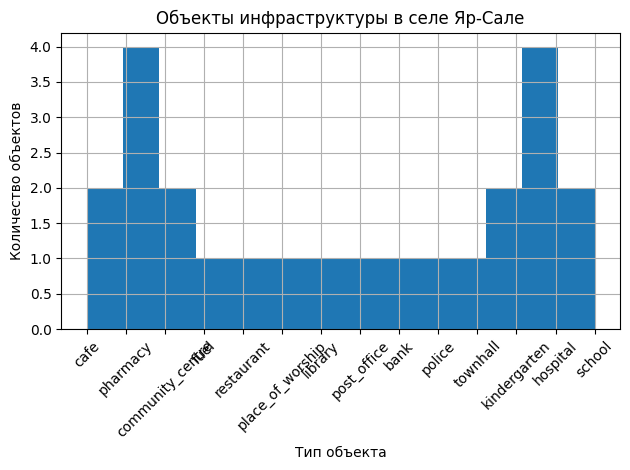

In [135]:
results['type'].hist(bins=len(results['type'].unique()))
plt.title('Объекты инфраструктуры в селе Яр-Сале')
plt.xticks(rotation=45)
plt.xlabel('Тип объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()
plt.show()

Как видно из диаграммы, наибольшее количество объектов по информации из OpenStreetMap представлено в категориях аптека (pharmacy) и детский сад (kindergarten). Данных объектов по 4 штуки каждого типа.

## Загрузка данных из предоставленного проекта

Теперь загрузим данные из предоставленного проекта.

In [136]:
# Путь к папке с данными
data_folder = '/content/drive/MyDrive/test_geo/data'

In [137]:
# Загружаю файлы с объектами POI
poi_point_path = f"{data_folder}/poi-point.gpkg"
poi_polygon_path = f"{data_folder}/poi-polygon.gpkg"

print("Загрузка точечных объектов POI...")
poi_point = gpd.read_file(poi_point_path)
print(f"Загружено {len(poi_point)} точечных объектов")

print("\nЗагрузка полигональных объектов POI...")
poi_polygon = gpd.read_file(poi_polygon_path)
print(f"Загружено {len(poi_polygon)} полигональных объектов")

# Анализирую структуру данных точечных объектов
print("\n=== Структура данных точечных объектов POI ===")
print(f"Количество строк: {len(poi_point)}")
print(f"Количество столбцов: {len(poi_point.columns)}")
print(f"Колонки: {poi_point.columns.tolist()}")

# Оцениваю типы точечных объектов
amenity_counts = poi_point['AMENITY'].value_counts()
print("\nТипы точечных объектов (AMENITY):")
for amenity, count in amenity_counts.items():
    if pd.notnull(amenity):  # Проверяю, что значение не NULL
        print(f"  {amenity}: {count}")

# Смотрю названия точечных объектов
print("\nПримеры названий точечных объектов:")
for i, name in enumerate(poi_point['NAME'].dropna().unique()):
    print(f"  {name}")
    if i >= 9:  # Ограничиваю вывод 10 примерами
        print("  ...")
        break

# Анализирую структуру данных полигональных объектов
print("\n=== Структура данных полигональных объектов POI ===")
print(f"Количество строк: {len(poi_polygon)}")
print(f"Количество столбцов: {len(poi_polygon.columns)}")
print(f"Колонки: {poi_polygon.columns.tolist()}")

# Смотрю типы полигональных объектов
if 'AMENITY' in poi_polygon.columns:
    amenity_counts_poly = poi_polygon['AMENITY'].value_counts()
    print("\nТипы полигональных объектов (AMENITY):")
    for amenity, count in amenity_counts_poly.items():
        if pd.notnull(amenity):  # Проверяем, что значение не NULL
            print(f"  {amenity}: {count}")
else:
    print("\nКолонка AMENITY отсутствует в полигональных объектах")

# Смотрю названия полигональных объектов
print("\nПримеры названий полигональных объектов:")
for i, name in enumerate(poi_polygon['NAME'].dropna().unique()):
    print(f"  {name}")
    if i >= 9:  # Ограничиваю вывод 10 примерами
        print("  ...")
        break

# Фильтрую точечные объекты социальной инфраструктуры
point_social = poi_point[poi_point.apply(is_social_infrastructure, axis=1)]
print(f"\nНайдено {len(point_social)} точечных объектов социальной инфраструктуры")

# Фильтрую полигональные объекты социальной инфраструктуры
polygon_social = poi_polygon[poi_polygon.apply(is_social_infrastructure, axis=1)]
print(f"Найдено {len(polygon_social)} полигональных объектов социальной инфраструктуры")

# Вывожу список точечных объектов социальной инфраструктуры
print("\n=== Точечные объекты социальной инфраструктуры ===")
for idx, row in point_social.iterrows():
    name = row.get('NAME', 'Без названия')
    if pd.isnull(name):
        name = 'Без названия'

    amenity = row.get('AMENITY', '')
    if pd.isnull(amenity):
        amenity = ''

    other_type = ''
    for col in ['SHOP', 'LEISURE', 'TOURISM', 'OFFICE', 'SPORT']:
        if pd.notnull(row.get(col)):
            other_type = f"{col}={row[col]}"
            break

    print(f"  {name} - Тип: {amenity} {other_type}")

# Вывожу список полигональных объектов социальной инфраструктуры
print("\n=== Полигональные объекты социальной инфраструктуры ===")
for idx, row in polygon_social.iterrows():
    name = row.get('NAME', 'Без названия')
    if pd.isnull(name):
        name = 'Без названия'

    amenity = row.get('AMENITY', '')
    if pd.isnull(amenity):
        amenity = ''

    other_type = ''
    for col in ['SHOP', 'LEISURE', 'TOURISM', 'OFFICE', 'SPORT']:
        if pd.notnull(row.get(col)):
            other_type = f"{col}={row[col]}"
            break

    print(f"  {name} - Тип: {amenity} {other_type}")

# Создаю пустой DataFrame для нормализованных данных
normalized_poi = pd.DataFrame(columns=['name', 'type', 'subtype', 'address', 'latitude', 'longitude', 'source'])

# Нормализую точечные объекты социальной инфраструктуры
for idx, row in point_social.iterrows():
    # Имя
    name = row.get('NAME', 'Без названия')
    if pd.isnull(name):
        name = 'Без названия'

    # Определяю тип
    obj_type = 'unknown'
    for type_col in ['AMENITY', 'SHOP', 'LEISURE', 'TOURISM', 'OFFICE', 'SPORT']:
        if pd.notnull(row.get(type_col)):
            obj_type = row[type_col]
            break

    # Координаты
    lon, lat = row.geometry.x, row.geometry.y

    # Добавляю в DataFrame
    new_row = pd.DataFrame({
        'name': [name],
        'type': [obj_type],
        'subtype': [''],
        'address': ['Яр-Сале'],
        'latitude': [lat],
        'longitude': [lon],
        'source': ['QGIS: poi-point']
    })

    normalized_poi = pd.concat([normalized_poi, new_row], ignore_index=True)

# Нормализую полигональные объекты социальной инфраструктуры
for idx, row in polygon_social.iterrows():
    # Имя
    name = row.get('NAME', 'Без названия')
    if pd.isnull(name):
        name = 'Без названия'

    # Определяю тип
    obj_type = 'unknown'
    for type_col in ['AMENITY', 'SHOP', 'LEISURE', 'TOURISM', 'OFFICE', 'SPORT']:
        if pd.notnull(row.get(type_col)):
            obj_type = row[type_col]
            break

    # Координаты центроида полигона
    centroid = row.geometry.centroid
    lon, lat = centroid.x, centroid.y

    # Добавляю в DataFrame
    new_row = pd.DataFrame({
        'name': [name],
        'type': [obj_type],
        'subtype': [''],
        'address': ['Яр-Сале'],
        'latitude': [lat],
        'longitude': [lon],
        'source': ['QGIS: poi-polygon']
    })
    normalized_poi = pd.concat([normalized_poi, new_row], ignore_index=True)


# Удаляю дубликаты
normalized_poi = deduplicate_by_coords(normalized_poi)

# Сохраняю нормализованные данные
normalized_poi.to_csv(f"{data_folder}/qgis_normalized_poi.csv", index=False, encoding='utf-8')
print(f"\nСохранено {len(normalized_poi)} нормализованных объектов социальной инфраструктуры")

# Информация о результатах
print("\n=== Результаты анализа ===")
print(f"Общее количество точечных объектов: {len(poi_point)}")
print(f"Общее количество полигональных объектов: {len(poi_polygon)}")
print(f"Найдено точечных объектов социальной инфраструктуры: {len(point_social)}")
print(f"Найдено полигональных объектов социальной инфраструктуры: {len(polygon_social)}")
print(f"Всего нормализованных объектов (без дубликатов): {len(normalized_poi)}")

Загрузка точечных объектов POI...
Загружено 30 точечных объектов

Загрузка полигональных объектов POI...
Загружено 90 полигональных объектов

=== Структура данных точечных объектов POI ===
Количество строк: 30
Количество столбцов: 13
Колонки: ['NAME', 'NAME_EN', 'NAME_RU', 'MAN_MADE', 'LEISURE', 'AMENITY', 'OFFICE', 'SHOP', 'TOURISM', 'SPORT', 'OSM_TYPE', 'OSM_ID', 'geometry']

Типы точечных объектов (AMENITY):
  pharmacy: 3
  cafe: 2
  driving_school: 1
  community_centre: 1
  doctors: 1
  fuel: 1
  restaurant: 1

Примеры названий точечных объектов:
  Перекрёсток
  Тура
  ЯЛЭМД
  Кафе "АЙС"
  Ямальские Олени
  Овощная Лавка
  Жар-Пицца
  Центр национальных культур
  Белая Медведица
  Завхоз
  ...

=== Структура данных полигональных объектов POI ===
Количество строк: 90
Количество столбцов: 13
Колонки: ['NAME', 'NAME_EN', 'NAME_RU', 'MAN_MADE', 'LEISURE', 'AMENITY', 'OFFICE', 'SHOP', 'TOURISM', 'SPORT', 'OSM_TYPE', 'OSM_ID', 'geometry']

Типы полигональных объектов (AMENITY):
  parking

<ipython-input-137-d6770b4f1667>:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  normalized_poi = pd.concat([normalized_poi, new_row], ignore_index=True)


Удалено 4 дубликатов по координатам

Сохранено 67 нормализованных объектов социальной инфраструктуры

=== Результаты анализа ===
Общее количество точечных объектов: 30
Общее количество полигональных объектов: 90
Найдено точечных объектов социальной инфраструктуры: 25
Найдено полигональных объектов социальной инфраструктуры: 45
Всего нормализованных объектов (без дубликатов): 67


Оценим теперь полученный результат

In [138]:
normalized_poi.head()

,name,type,subtype,address,latitude,longitude,source
0,Перекрёсток,farm,,Яр-Сале,66.865712,70.837139,QGIS: poi-point
1,Тура,houseware,,Яр-Сале,66.857607,70.846782,QGIS: poi-point
2,ЯЛЭМД,hotel,,Яр-Сале,66.859157,70.844556,QGIS: poi-point
3,"Кафе ""АЙС""",cafe,,Яр-Сале,66.866210,70.839189,QGIS: poi-point
4,Без названия,hairdresser,,Яр-Сале,66.863297,70.838964,QGIS: poi-point


In [139]:
normalized_poi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 0 to 69
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       67 non-null     object 
 1   type       67 non-null     object 
 2   subtype    67 non-null     object 
 3   address    67 non-null     object 
 4   latitude   67 non-null     float64
 5   longitude  67 non-null     float64
 6   source     67 non-null     object 
dtypes: float64(2), object(5)
memory usage: 6.2+ KB


Очевидно, что в таблице 67 строк и 7 столбцов. Посмотрим на распределение объектов по типам.

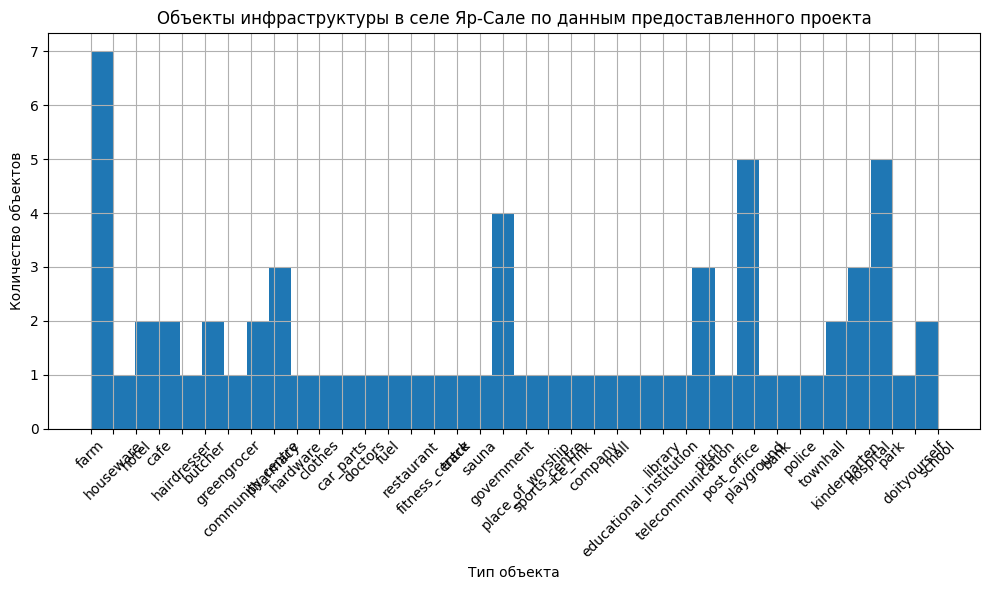

In [140]:
plt.figure(figsize=(10, 6))
normalized_poi['type'].hist(bins=len(normalized_poi['type'].unique()))
plt.title('Объекты инфраструктуры в селе Яр-Сале по данным предоставленного проекта')
plt.xticks(rotation=45)
plt.xlabel('Тип объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()
plt.show()

Типов объектов и самих объектов получилось больше. Так, больше всех в таблице представлено ферм, детских садов и объектов связи. Наслоение обозначений связано с тем, что некоторых объектов одинаковое количество.

## Сведение информации из обоих источников

Теперь совместим информацию из обоих источников в одну большую таблицу.

In [141]:
# Проверяю доступность данных
print(f"Данные из QGIS: {len(normalized_poi)} объектов")
print(f"Данные из OSM: {len(results)} объектов")


# Сопоставляю объекты
match_results = match_poi_by_coordinates(normalized_poi, results)

# Вывожу статистику
print("\n=== Результаты сопоставления ===")
print(f"Всего объектов в QGIS: {match_results['stats']['total_qgis']}")
print(f"Всего объектов в OSM: {match_results['stats']['total_osm']}")
print(f"Найдено соответствий: {match_results['stats']['matches']}")
print(f"Объекты только в QGIS: {match_results['stats']['only_in_qgis']}")
print(f"Объекты только в OSM: {match_results['stats']['only_in_osm']}")

# Сравниваю типы объектов
if not match_results['matches'].empty:
    print("\n=== Сравнение объектов, найденных в обоих источниках ===")
    comparison = match_results['matches'][['qgis_name', 'osm_name', 'qgis_type', 'osm_type']]
    print(comparison.to_string())

# Объекты, найденные только в QGIS
print("\n=== Объекты, найденные только в QGIS ===")
if len(match_results['qgis_only']) > 0:
    qgis_only_subset = match_results['qgis_only'][['name', 'type', 'latitude', 'longitude']]
    print(qgis_only_subset.to_string())
else:
    print("Нет объектов, найденных только в QGIS")

# Объекты, найденные только в OSM
print("\n=== Объекты, найденные только в OSM ===")
if len(match_results['osm_only']) > 0:
    osm_only_subset = match_results['osm_only'][['name', 'type', 'latitude', 'longitude']]
    print(osm_only_subset.to_string())
else:
    print("Нет объектов, найденных только в OSM")

# Создаю объединенный набор данных
combined_poi = create_combined_dataset(match_results, normalized_poi, results)
print(f"\n=== Объединенный набор данных ===")
print(f"Всего объектов: {len(combined_poi)}")


Данные из QGIS: 67 объектов
Данные из OSM: 24 объектов

=== Результаты сопоставления ===
Всего объектов в QGIS: 67
Всего объектов в OSM: 24
Найдено соответствий: 23
Объекты только в QGIS: 44
Объекты только в OSM: 1

=== Сравнение объектов, найденных в обоих источниках ===
                                                qgis_name                                               osm_name         qgis_type          osm_type
0                                              Кафе "АЙС"                                             Кафе "АЙС"              cafe              cafe
1                                            Без названия                                                    NaN       hairdresser          pharmacy
2                                               Жар-Пицца                                              Жар-Пицца              cafe              cafe
3                              Центр национальных культур                             Центр национальных культур  community_centre 

Посмотрим на получившуюся таблицу

In [142]:
combined_poi.head()

,name,type,subtype,address,latitude,longitude,source
0,Перекрёсток,farm,,Яр-Сале,66.865712,70.837139,QGIS: poi-point
1,Тура,houseware,,Яр-Сале,66.857607,70.846782,QGIS: poi-point
2,ЯЛЭМД,hotel,,Яр-Сале,66.859157,70.844556,QGIS: poi-point
3,Ямальские Олени,butcher,,Яр-Сале,66.863438,70.838828,QGIS: poi-point
4,Овощная Лавка,greengrocer,,Яр-Сале,66.862677,70.837379,QGIS: poi-point


In [143]:
combined_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       63 non-null     object 
 1   type       68 non-null     object 
 2   subtype    55 non-null     object 
 3   address    68 non-null     object 
 4   latitude   68 non-null     float64
 5   longitude  68 non-null     float64
 6   source     68 non-null     object 
dtypes: float64(2), object(5)
memory usage: 3.8+ KB


В таблице 68 строк, но в некоторых столбцах есть пропуски. Посмотрим теперь опять на распределение типов объектов.

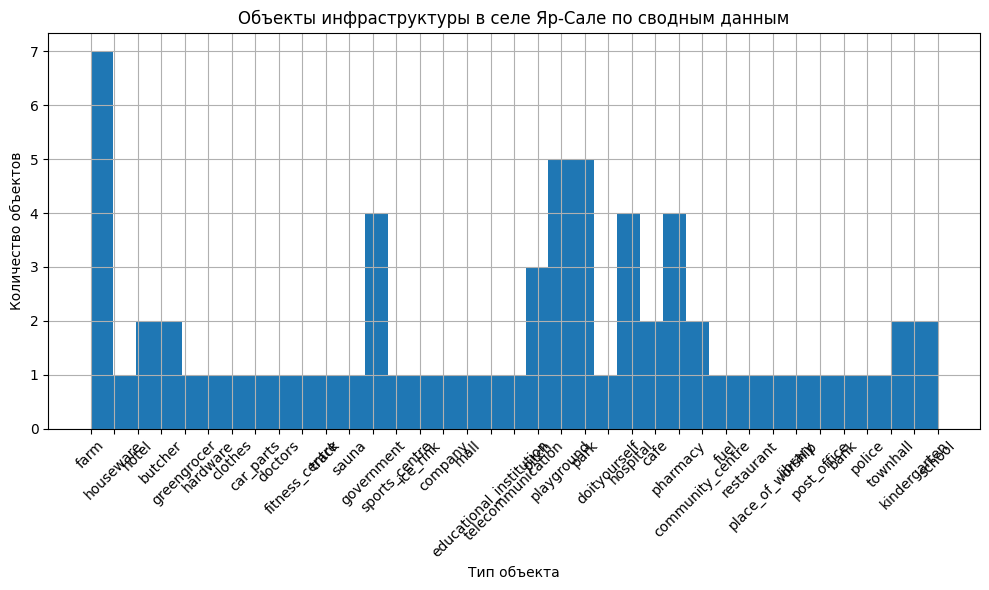

In [144]:
plt.figure(figsize=(10, 6))
combined_poi['type'].hist(bins=len(combined_poi['type'].unique()))
plt.title('Объекты инфраструктуры в селе Яр-Сале по сводным данным')
plt.xticks(rotation=45)
plt.xlabel('Тип объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()
plt.show()

Как видно, распределение типов объектов изменилось, но лидер остался - количество ферм больше.

## Получение информации из Яндекс-карт

Для выгрузки воспользуемся бесплатным ключом API для HTTP Геокодера Яндекса

In [145]:
api_key = "f2c06a9f-c62e-4f88-943b-717eba10327d"

In [146]:
yandex_data = get_infrastructure_data_with_existing_names(api_key, combined_poi)

Найдено 50 уникальных названий в существующем датасете
Примеры названий объектов:
  - Перекрёсток
  - Тура
  - ЯЛЭМД
  - Ямальские Олени
  - Овощная Лавка
  - Белая Медведица
  - Завхоз
  - Фруктовый Рай
  - Cicilia
  - Ямальский
Найдено 37 уникальных типов объектов в существующем датасете
Поиск по названию: Перекрёсток
Поиск по названию: Тура
Поиск по названию: ЯЛЭМД
Поиск по названию: Ямальские Олени
Поиск по названию: Овощная Лавка
Поиск по названию: Белая Медведица
Поиск по названию: Завхоз
Поиск по названию: Фруктовый Рай
Поиск по названию: Cicilia
Поиск по названию: Ямальский
Поиск по названию: Вавилон
Поиск по названию: ИТД
Поиск по названию: Без названия
Поиск по названию: Магазин-СТО "ЛИДЕР"
Поиск по названию: Поликлиника
Поиск по названию: Арктика
Поиск по названию: Баня
Поиск по названию: Администрация МО Ямальский район
Поиск по названию: Пенсионный фонд
Поиск по названию: Спортивно-оздоровительный центр "Арктика"
Поиск по названию: ДЮСШОР "Лидер"
Поиск по названию: Управле

In [147]:
# Использую функцию для объединения данных
final_data = merge_datasets(yandex_data, combined_poi)

# Базовая статистика по итоговому датасету
print("\nСтатистика по итоговому датасету:")
print(f"Количество объектов с указанной улицей: {final_data['street'].notna().sum()} из {len(final_data)}")
print(f"Количество объектов с указанным номером дома: {final_data['house_number'].notna().sum()} из {len(final_data)}")
print(f"Распределение по типам объектов:")
print(final_data['type'].value_counts().head(10))

Исходное количество записей в Яндекс данных: 94
Исходное количество записей в комбинированных данных: 68
Количество записей после простого объединения: 162
Итоговое количество записей после удаления дубликатов: 157

Статистика по итоговому датасету:
Количество объектов с указанной улицей: 0 из 157
Количество объектов с указанным номером дома: 0 из 157
Распределение по типам объектов:
type
farm                19
park                13
hospital            11
government           7
cafe                 6
community_centre     6
kindergarten         6
butcher              6
hotel                6
pharmacy             6
Name: count, dtype: int64


In [148]:
final_data

,name,type,subtype,address,latitude,longitude,source,street,house_number
0,Cicilia,clothes,"Ямальский район, Россия","Россия, Ямальский район, пристань Яр-Сале",66.855939,70.852714,Яндекс.Геокодер,None,None
1,Cicilia,clothes,"Ямальский район, Россия","Россия, Ямальский район, село Яр-Сале",66.860618,70.844018,Яндекс.Геокодер,None,None
2,Cicilia,clothes,,Яр-Сале,66.869537,70.831195,QGIS: poi-point,None,None
3,"АО ""Ямалкомунэнерго""",company,"Ямальский район, Россия","Россия, Ямальский район, пристань Яр-Сале",66.855939,70.852714,Яндекс.Геокодер,None,None
4,"АО ""Ямалкомунэнерго""",company,"Ямальский район, Россия","Россия, Ямальский район, село Яр-Сале",66.860618,70.844018,Яндекс.Геокодер,None,None
...,...,...,...,...,...,...,...,...,...
152,Ямальский,farm,"Ямальский район, Россия","Россия, Ямальский район, пристань Яр-Сале",66.855939,70.852714,Яндекс.Геокодер,None,None
153,Ямальский,farm,"Ямальский район, Россия","Россия, Ямальский район, село Яр-Сале",66.860618,70.844018,Яндекс.Геокодер,None,None
154,Ямальский,farm,,Яр-Сале,66.862800,70.836511,QGIS: poi-point,None,None
155,Яр-Салинская центральная районная больница,hospital,NaN,"ул. nan, д. nan",66.859239,70.840288,OpenStreetMap,None,None


У нас много строк, значительно больше, чем было из других проектов. Отсортируем таблицу и оставим только нужные строки с наиболее полными адресами.

In [149]:
# Добавляю временный столбец с оценкой качества адреса
final_data['address_score'] = final_data.apply(address_quality_score, axis=1)

# Сортирую по score в убывающем порядке в пределах каждой группы
final_data = final_data.sort_values(['name', 'type', 'address_score'], ascending=[True, True, False])

# Обрабатываю отдельно строки с name == 'Без названия' и остальные
unnamed_mask = final_data['name'] == 'Без названия'

# Для строк с 'Без названия' удаляю дубликаты по типу, оставляя строку с лучшим адресом
unnamed_rows = final_data[unnamed_mask].drop_duplicates(subset=['type'])

# Для остальных строк удаляю дубликаты по имени и типу
other_rows = final_data[~unnamed_mask].drop_duplicates(subset=['name', 'type'])

# Объединяю результаты
final_data = pd.concat([unnamed_rows, other_rows])

# Удаляю временный столбец с оценкой
final_data = final_data.drop(columns=['address_score'])

# Сбрасываю индекс
final_data = final_data.reset_index(drop=True)

Удалим лишние столбцы и посмотрим на конечную таблицу.

In [150]:
final_data = final_data.drop(['street', 'house_number'], axis=1)

In [151]:
final_data.head()

,name,type,subtype,address,latitude,longitude,source
0,Без названия,educational_institution,,Яр-Сале,66.862060,70.841444,QGIS: poi-polygon
1,Без названия,farm,,Яр-Сале,66.859355,70.845678,QGIS: poi-polygon
2,Без названия,government,,Яр-Сале,66.861405,70.842842,QGIS: poi-polygon
3,Без названия,hotel,,Яр-Сале,66.862321,70.844209,QGIS: poi-point
4,Без названия,park,,Яр-Сале,66.859865,70.841662,QGIS: poi-polygon


In [152]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       57 non-null     object 
 1   type       57 non-null     object 
 2   subtype    47 non-null     object 
 3   address    57 non-null     object 
 4   latitude   57 non-null     float64
 5   longitude  57 non-null     float64
 6   source     57 non-null     object 
dtypes: float64(2), object(5)
memory usage: 3.2+ KB


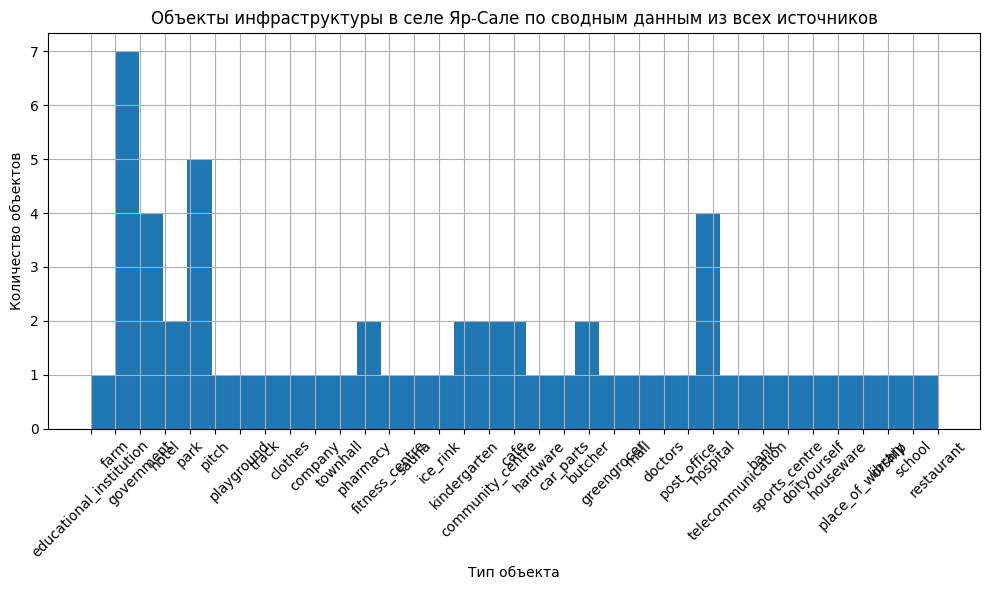

In [153]:
plt.figure(figsize=(10, 6))
final_data['type'].hist(bins=len(final_data['type'].unique()))
plt.title('Объекты инфраструктуры в селе Яр-Сале по сводным данным из всех источников')
plt.xticks(rotation=45)
plt.xlabel('Тип объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()
plt.show()

После удаления всех дубликатов и сведения информации из всех источников больше всех также ферм. Их 7 объектов. На втором месте парков и почтовых отделений. Для нескольких объектов не удалось установить адрес и названия, но известен тип.

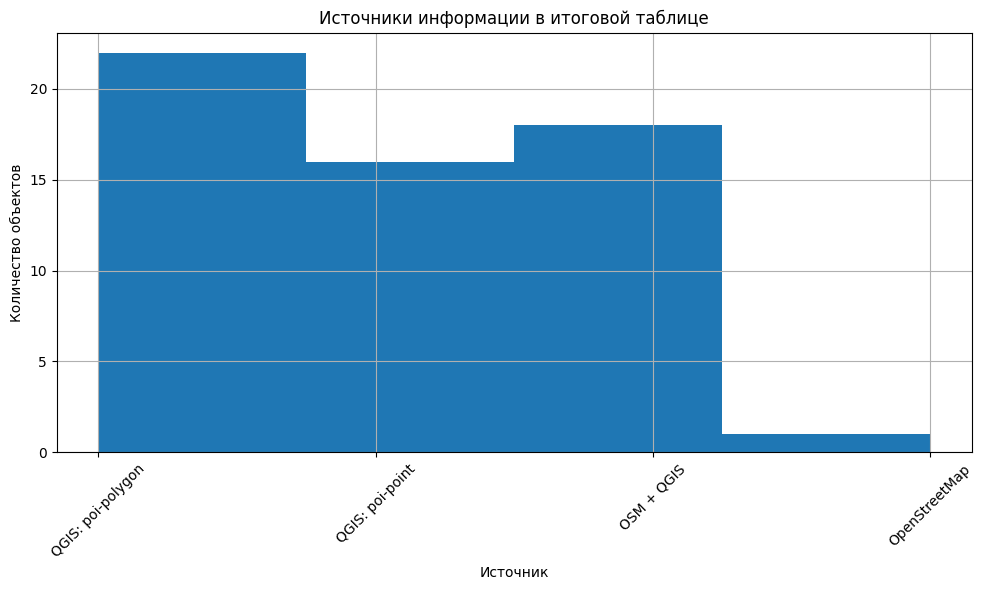

In [154]:
plt.figure(figsize=(10, 6))
final_data['source'].hist(bins=len(final_data['source'].unique()))
plt.title('Источники информации в итоговой таблице')
plt.xticks(rotation=45)
plt.xlabel('Источник')
plt.ylabel('Количество объектов')
plt.tight_layout()
plt.show()

Сохраним результат в виде таблицы для передачи в проект.

In [155]:
final_data.to_csv('infrastructure_yarsale.csv', index=False, encoding='utf-8')